1. 加载 CSV 文件

In [ ]:
import pandas as pd

file_path = "test.csv"
data = pd.read_csv(file_path)
print(data.head())

# 提取评论列
reviews = data['review']


   Unnamed: 0                                           film-url  \
0           0  http://www.allocine.fr/film/fichefilm-25385/cr...   
1           1  http://www.allocine.fr/film/fichefilm-1954/cri...   
2           2  http://www.allocine.fr/film/fichefilm-135523/c...   
3           3  http://www.allocine.fr/film/fichefilm-61514/cr...   
4           4  http://www.allocine.fr/film/fichefilm-260395/c...   

                                              review  polarity  
0  Magnifique épopée, une belle histoire, touchan...         1  
1  Je n'ai pas aimé mais pourtant je lui mets 2 é...         0  
2  Un dessin animé qui brille par sa féerie et se...         1  
3  Si c'est là le renouveau du cinéma français, c...         0  
4  Et pourtant on s’en Doutait !Second volet très...         0  


2. 分句

In [16]:
import nltk
nltk.download('punkt')

def split_into_sentences(text):
    return nltk.sent_tokenize(text, language='french')

# 对每条评论进行分句
sentences = reviews.apply(split_into_sentences)

# 将分句结果展开成一个句子列表
sentences_list = [sentence for review in sentences for sentence in review]


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


3. 筛选目标词上下文

In [ ]:
# 定义目标词列表
target_words = ["coeur", "banc"]

def extract_contexts(sentences, target_words):
    contexts = {word: [] for word in target_words} 
    for sentence in sentences:
        for word in target_words:
            if word in sentence:
                contexts[word].append(sentence)
    return contexts

# 提取多个目标词的上下文
contexts_dict = extract_contexts(sentences_list, target_words)

# 检查结果
for word, contexts in contexts_dict.items():
    print(f"目标词 '{word}' 找到 {len(contexts)} 个上下文句子")
    print(contexts[:3])


目标词 'coeur' 找到 345 个上下文句子
["Ces scènes dans la neige, c'est tendre, c'est beau, ça tranche avec le reste et ça donne du coeur à l'amourette, ça aide à le faire paraître comme une évidence.", 'C\'est bien gentil de vouloir faire un film sur l\'amour ,theme ultra classique au cinéma s\'il en est ,mais il faut quand meme veiller a ne pas trop charger la barque car a force de voir degouliner la guimauve sentimentale ,celle ci finit par ecoeurer qu\'elle ne captive.Etre le scenariste des dernieres bonnes comedies Anglaises est une chose ,ca aide notament a reunir un casting " musclé " mais realisateur n\'en deplaise a Mr Curtis c\'est un vrai metier !', "Pleins de verve, les comédiens se donnent à coeur joie dans l'interprétation des dialogues : Nathalie Baye en tête, incroyablement réaliste en candidate de droite sans aucun scrupule, prête à faire des alliances malsaines avec l'extrême-droite pour remporter l'élection à la mairie."]
目标词 'banc' 找到 95 个上下文句子
["très bon thriller, comme d'habi

In [18]:
# 按目标词保存上下文
for word, contexts in contexts_dict.items():
    file_name = f"contexts2_{word}.txt"
    with open(file_name, "w", encoding="utf-8") as f:
        for sentence in contexts:
            f.write(sentence + "\n")


4. 嵌入生成

In [19]:
from transformers import AutoTokenizer, AutoModel
import torch

# 加载 BERT 模型
model_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# 保存所有嵌入的结果
all_embeddings = {}

for word, contexts in contexts_dict.items():
    embeddings = []
    for sentence in contexts:
        # 分词并获取模型输入
        inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        last_hidden_states = outputs.last_hidden_state

        # 提取目标词的嵌入
        token_ids = tokenizer.encode(word, add_special_tokens=False)
        word_indices = [i for i, token_id in enumerate(inputs["input_ids"][0]) if token_id in token_ids]

        # 平均多个子词嵌入
        if word_indices:
            word_embedding = last_hidden_states[0, word_indices, :].mean(dim=0)
            embeddings.append(word_embedding.numpy())

    # 保存嵌入
    all_embeddings[word] = embeddings
    print(f"目标词 '{word}' 生成了 {len(embeddings)} 个嵌入")


目标词 'coeur' 生成了 313 个嵌入
目标词 'banc' 生成了 8 个嵌入


In [20]:
import numpy as np

for word, embeddings in all_embeddings.items():
    embeddings_array = np.array(embeddings)
    np.save(f"{word}_embeddings.npy", embeddings_array)

5. 分析与可视化

5. 1 计算嵌入之间的余弦相似度

In [21]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# 加载嵌入向量
word = "coeur"
embeddings = np.load(f"{word}_embeddings.npy")

# 计算余弦相似度矩阵
similarity_matrix = cosine_similarity(embeddings)

# 打印矩阵形状和部分内容
print(f"余弦相似度矩阵形状: {similarity_matrix.shape}")
print(similarity_matrix[:5, :5])


余弦相似度矩阵形状: (313, 313)
[[0.9999999  0.66819036 0.70956254 0.72288346 0.7405355 ]
 [0.66819036 1.0000001  0.56228334 0.7045671  0.6523354 ]
 [0.70956254 0.56228334 0.99999964 0.69092333 0.6956166 ]
 [0.72288346 0.7045671  0.69092333 0.9999998  0.722583  ]
 [0.7405355  0.6523354  0.6956166  0.722583   0.9999999 ]]


5. 2 计算多义性评分

In [22]:
# 提取非对角线元素
n = len(embeddings)
off_diagonal_elements = similarity_matrix[np.triu_indices(n, k=1)]  

# 计算标准差
polysemy_score = np.std(off_diagonal_elements)
print(f"目标词 '{word}' 的多义性评分: {polysemy_score}")


目标词 'coeur' 的多义性评分: 0.07810300588607788


5. 3 可视化余弦相似度

C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 19979 (\N{CJK UNIFIED IDEOGRAPH-4E0B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25991 (\N{CJK UNIFIED IDEOGRAPH-6587}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\

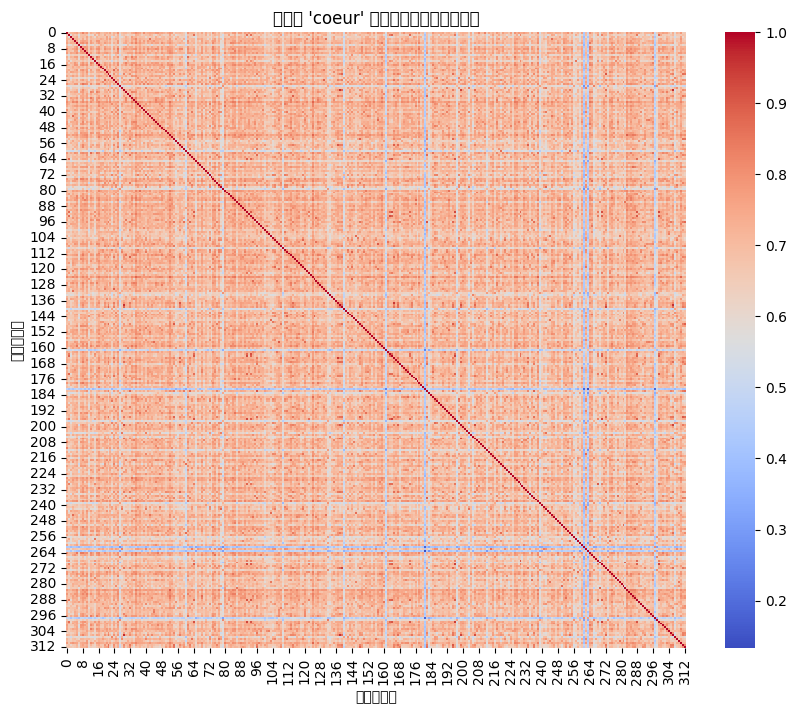

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# 绘制相似度矩阵的热图
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=False, cmap="coolwarm")
plt.title(f"目标词 '{word}' 的上下文嵌入相似度矩阵")
plt.xlabel("上下文编号")
plt.ylabel("上下文编号")
plt.show()


5. 4 结合降维

C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32500 (\N{CJK UNIFIED IDEOGRAPH-7EF4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30446 (\N{CJK UNIFIED IDEOGRAPH-76EE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\

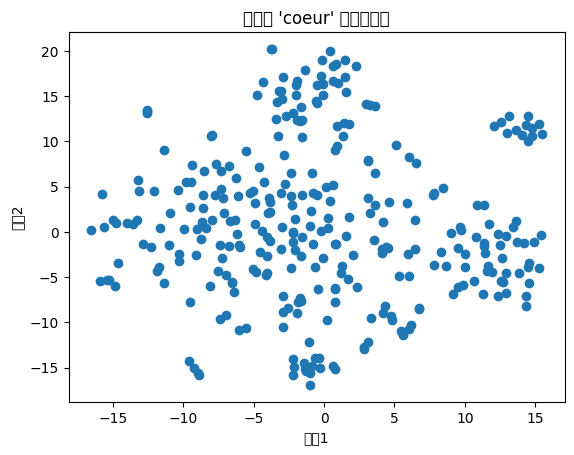

In [24]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 对某个目标词的嵌入降维
word = "coeur"
embeddings = np.load(f"{word}_embeddings.npy")
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

# 绘制分布
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])
plt.title(f"目标词 '{word}' 的嵌入分布")
plt.xlabel("维度1")
plt.ylabel("维度2")
plt.show()
